In [259]:
import pandas as pd
from pathlib import Path
import os

PROJECT_ROOT = Path("..")
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "heart_disease_cleaned.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [260]:
X = df.drop("target", axis=1)
y = df["target"]

In [261]:
categorical_features = [
    "sex", "cp", "fbs", "restecg",
    "exang", "slope", "thal"
]

numerical_features = [
    "age", "trestbps", "chol",
    "thalach", "oldpeak", "ca"
]
print("Feature separation completed.")

Feature separation completed.


In [262]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Data split into training and testing sets.")

Data split into training and testing sets.


In [264]:
from sklearn.linear_model import LogisticRegression

log_reg_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak',
                                                   'ca']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'thal'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [265]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak',
                                                   'ca']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'thal'])])),
                ('model',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [266]:
from sklearn.model_selection import cross_validate

scoring = ["accuracy", "precision", "recall", "roc_auc"]
lr_cv = cross_validate(
    log_reg_pipeline,
    X_train, y_train,
    cv=5,
    scoring=scoring
)
print("Logistic Regression Cross-Validation results:")
lr_cv


Logistic Regression Cross-Validation results:


{'fit_time': array([0.05852914, 0.04129672, 0.02634025, 0.0348196 , 0.03015208]),
 'score_time': array([0.06049609, 0.03790855, 0.02254534, 0.03585815, 0.00986218]),
 'test_accuracy': array([0.91836735, 0.79591837, 0.8125    , 0.83333333, 0.77083333]),
 'test_precision': array([1.        , 0.8       , 0.80952381, 0.81818182, 0.78947368]),
 'test_recall': array([0.82608696, 0.72727273, 0.77272727, 0.81818182, 0.68181818]),
 'test_roc_auc': array([0.95317726, 0.84680135, 0.91083916, 0.93181818, 0.8548951 ])}

In [267]:
rf_cv = cross_validate(
    rf_pipeline,
    X_train, y_train,
    cv=5,
    scoring=scoring
)
print("Random Forest Cross-Validation results:")
rf_cv


Random Forest Cross-Validation results:


{'fit_time': array([0.6334784 , 0.55558515, 0.42247319, 0.51889515, 0.35052967]),
 'score_time': array([0.03045893, 0.09658742, 0.11376166, 0.04621124, 0.04878998]),
 'test_accuracy': array([0.83673469, 0.7755102 , 0.83333333, 0.72916667, 0.75      ]),
 'test_precision': array([0.82608696, 0.76190476, 0.81818182, 0.69565217, 0.77777778]),
 'test_recall': array([0.82608696, 0.72727273, 0.81818182, 0.72727273, 0.63636364]),
 'test_roc_auc': array([0.9506689 , 0.84680135, 0.90384615, 0.87587413, 0.86451049])}

In [268]:
import numpy as np

def summarize_cv_results(cv_results):
    return {
        metric: np.mean(cv_results[f"test_{metric}"])
        for metric in scoring
    }

lr_results = summarize_cv_results(lr_cv)
rf_results = summarize_cv_results(rf_cv)

pd.DataFrame([lr_results, rf_results],
             index=["Logistic Regression", "Random Forest"])


,accuracy,precision,recall,roc_auc
Logistic Regression,0.826190,0.843436,0.765217,0.899506
Random Forest,0.784949,0.775921,0.747036,0.888340


In [269]:
import mlflow
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

MLFLOW_TRACKING_URI = os.getenv(
    "MLFLOW_TRACKING_URI",
    "file:../mlruns",
)


mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Heart Disease Classification")

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    RocCurveDisplay
)
import matplotlib.pyplot as plt


In [270]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob)
    }
    return metrics, y_prob


Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



c:\Users\SESA661370\AppData\Local\Programs\Python\Python310\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\SESA661370\AppData\Local\Programs\Python\Python310\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Text(50.722222222222214, 0.5, 'Actual')

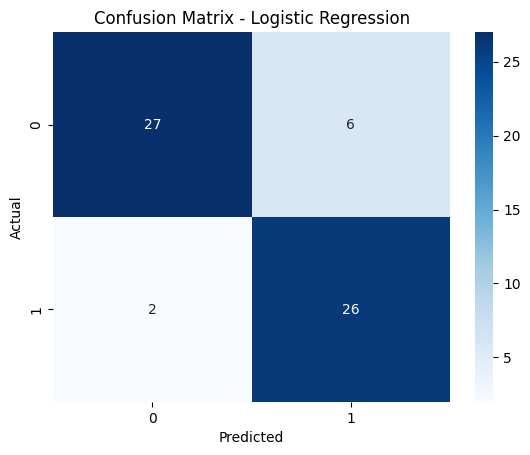

In [271]:
with mlflow.start_run(run_name="Logistic Regression"):
    # Log parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("max_iter", 1000)

    # Train model
    log_reg_pipeline.fit(X_train, y_train)

    # Evaluate
    metrics, y_prob = evaluate_model(
        log_reg_pipeline, X_test, y_test
    )

    # Log metrics
    for key, value in metrics.items():
        mlflow.log_metric(key, value)

    # ROC Curve
    RocCurveDisplay.from_estimator(
        log_reg_pipeline, X_test, y_test
    )
    plt.title("ROC Curve - Logistic Regression")
    plt.savefig("roc_logistic.png")
    mlflow.log_artifact("roc_logistic.png")
    plt.close()

    # Log model
    mlflow.sklearn.log_model(
        log_reg_pipeline,
        artifact_path="model"
    )

from sklearn.metrics import classification_report
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred))

y_pred = log_reg_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")


c:\Users\SESA661370\AppData\Local\Programs\Python\Python310\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\SESA661370\AppData\Local\Programs\Python\Python310\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



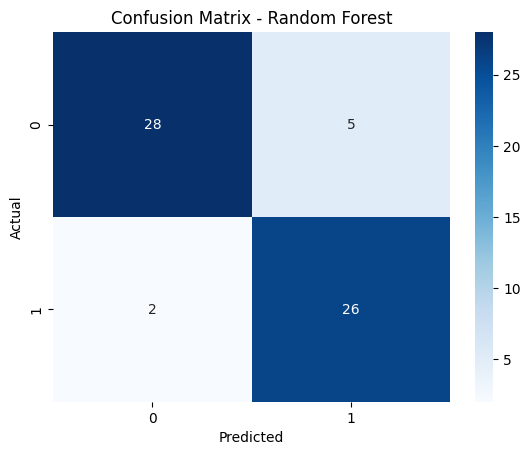

In [272]:
with mlflow.start_run(run_name="Random Forest"):
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 200)

    rf_pipeline.fit(X_train, y_train)

    metrics, y_prob = evaluate_model(
        rf_pipeline, X_test, y_test
    )

    for key, value in metrics.items():
        mlflow.log_metric(key, value)

    RocCurveDisplay.from_estimator(
        rf_pipeline, X_test, y_test
    )
    plt.title("ROC Curve - Random Forest")
    plt.savefig("roc_rf.png")
    mlflow.log_artifact("roc_rf.png")
    plt.close()

    mlflow.sklearn.log_model(
        rf_pipeline,
        artifact_path="model"
    )

    from sklearn.metrics import classification_report
    print("Random Forest Classification Report")
    print(classification_report(y_test, y_pred))

    y_pred = rf_pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Random Forest")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

In [273]:
mlflow.get_experiment_by_name("Heart Disease Classification")
print("Experiment retrieval completed.")

Experiment retrieval completed.
